# Building all models and SHAP analysis
Using src.model_builder I build models for each cell type and gene of interest. Totalling 28 models (there are 4 more to go for cell type Mast). 

In [41]:
import src.model_builder as mb
import src.modules as modules
import pandas as pd
import xgboost as xgb

In [51]:
%load_ext autoreload
%autoreload 2

In [6]:
cell_types = ['B_cell', 'EC', 'Myeloid', 'Cancer', 'Fibroblast', 'T_cell', 'DC', 'Mast']
genes = ["ESR1", "ERBB2", "CDK1", "CDK4"]

The models are organized in a dictionary of dictionary where each cell type has its own class containing the genes. Individual models can be accessed with `models[cell_type][gene]`

## Binary model predicting 'low' or 'high' expression, zero expressions are removed

In [313]:
binary = mb.CellLevelModel("Cancer", ["ESR1"])
binary.build_datasets(output_type="binary", differentially_expressed = 1)

Building ESR1...(1599, 1000) (1599,) 1055
 Completed


In [314]:
binary.build_model(model_params, cv=False)

CANCER - ESR1 


-------------ESR1-------------
   Building prediction model for ESR1 using early stopping ...
MODEL BUILDING COMPLETE




In [ ]:
binary_

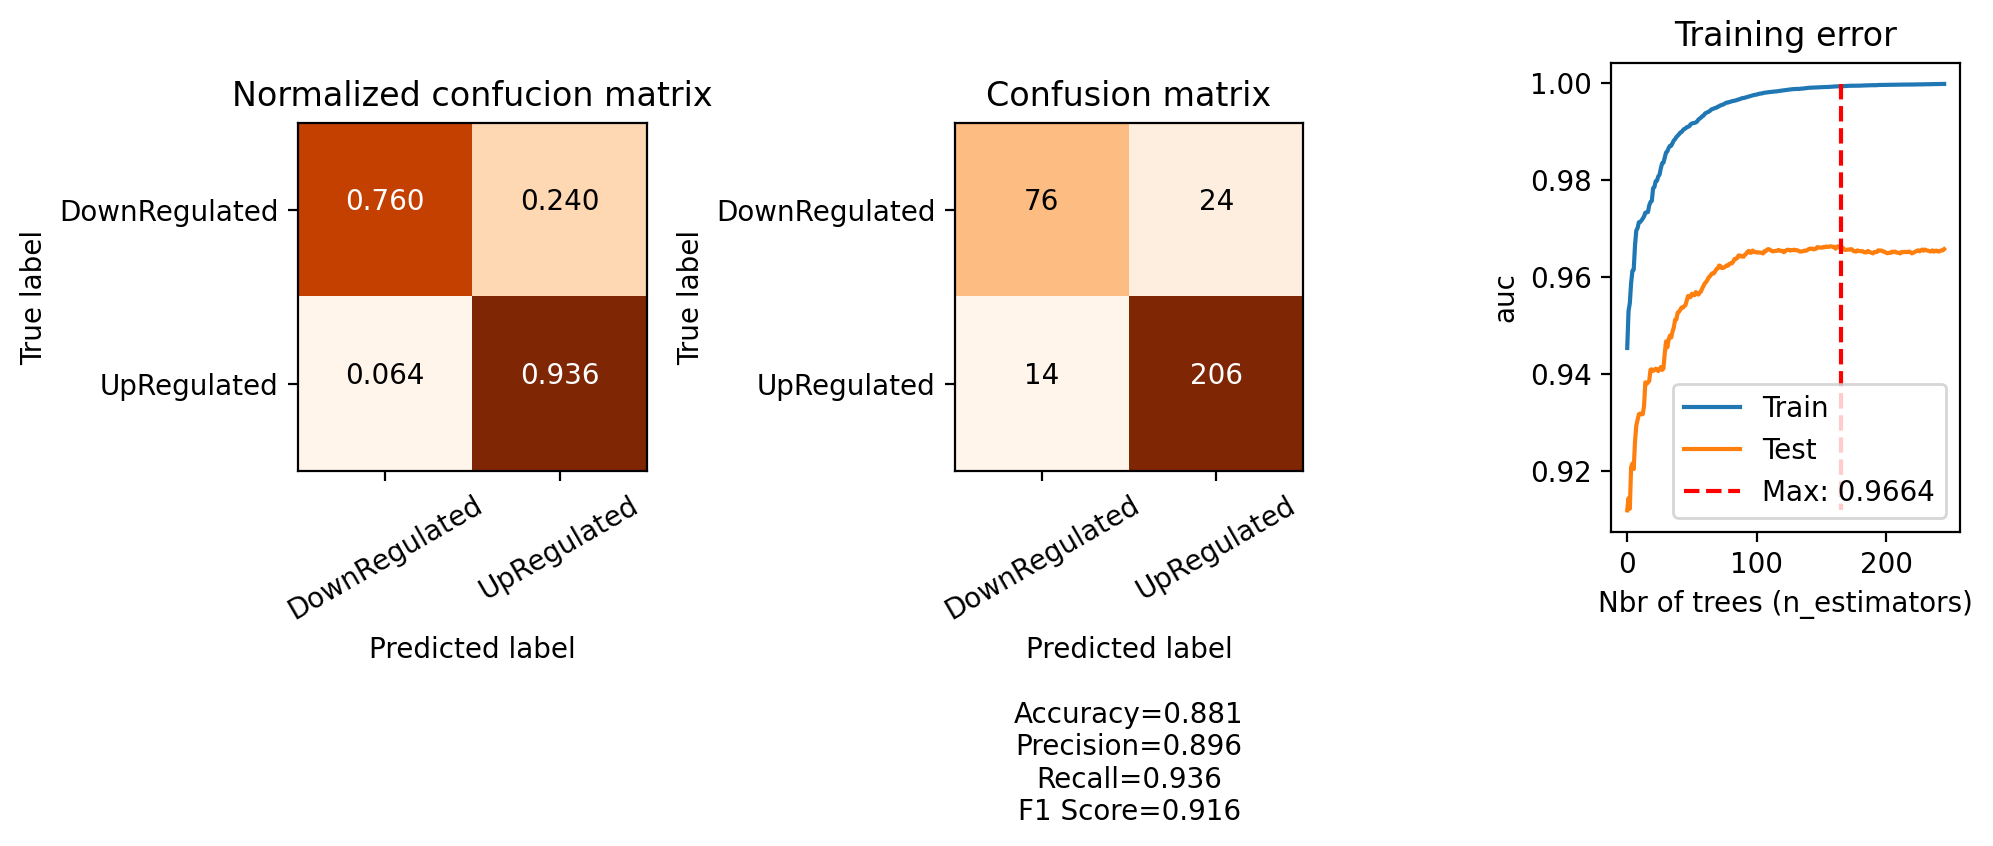

In [339]:
binary.plot_results("ESR1", figsize=(10,4))

In [340]:
binary_low = mb.CellLevelModel("Cancer", ["ESR1"])
binary_low.build_datasets(output_type="binary", differentially_expressed = 0.5)

Building ESR1 dataset...Computing correlations and selecting input variables


  0%|          | 0/28635 [00:00<?, ?it/s]

Making classificaion datasets!!! Completed


In [352]:
binary_low.build_model(model_params, cv=5)


CANCER - ESR1 

   ESR1:
      Performing 5 fold cross-validation on ESR1 -  579 iters
      auc: 0.9296068
      Building classification model for ESR1, n_estimators=579 ... Complete
MODEL BUILDING COMPLETE




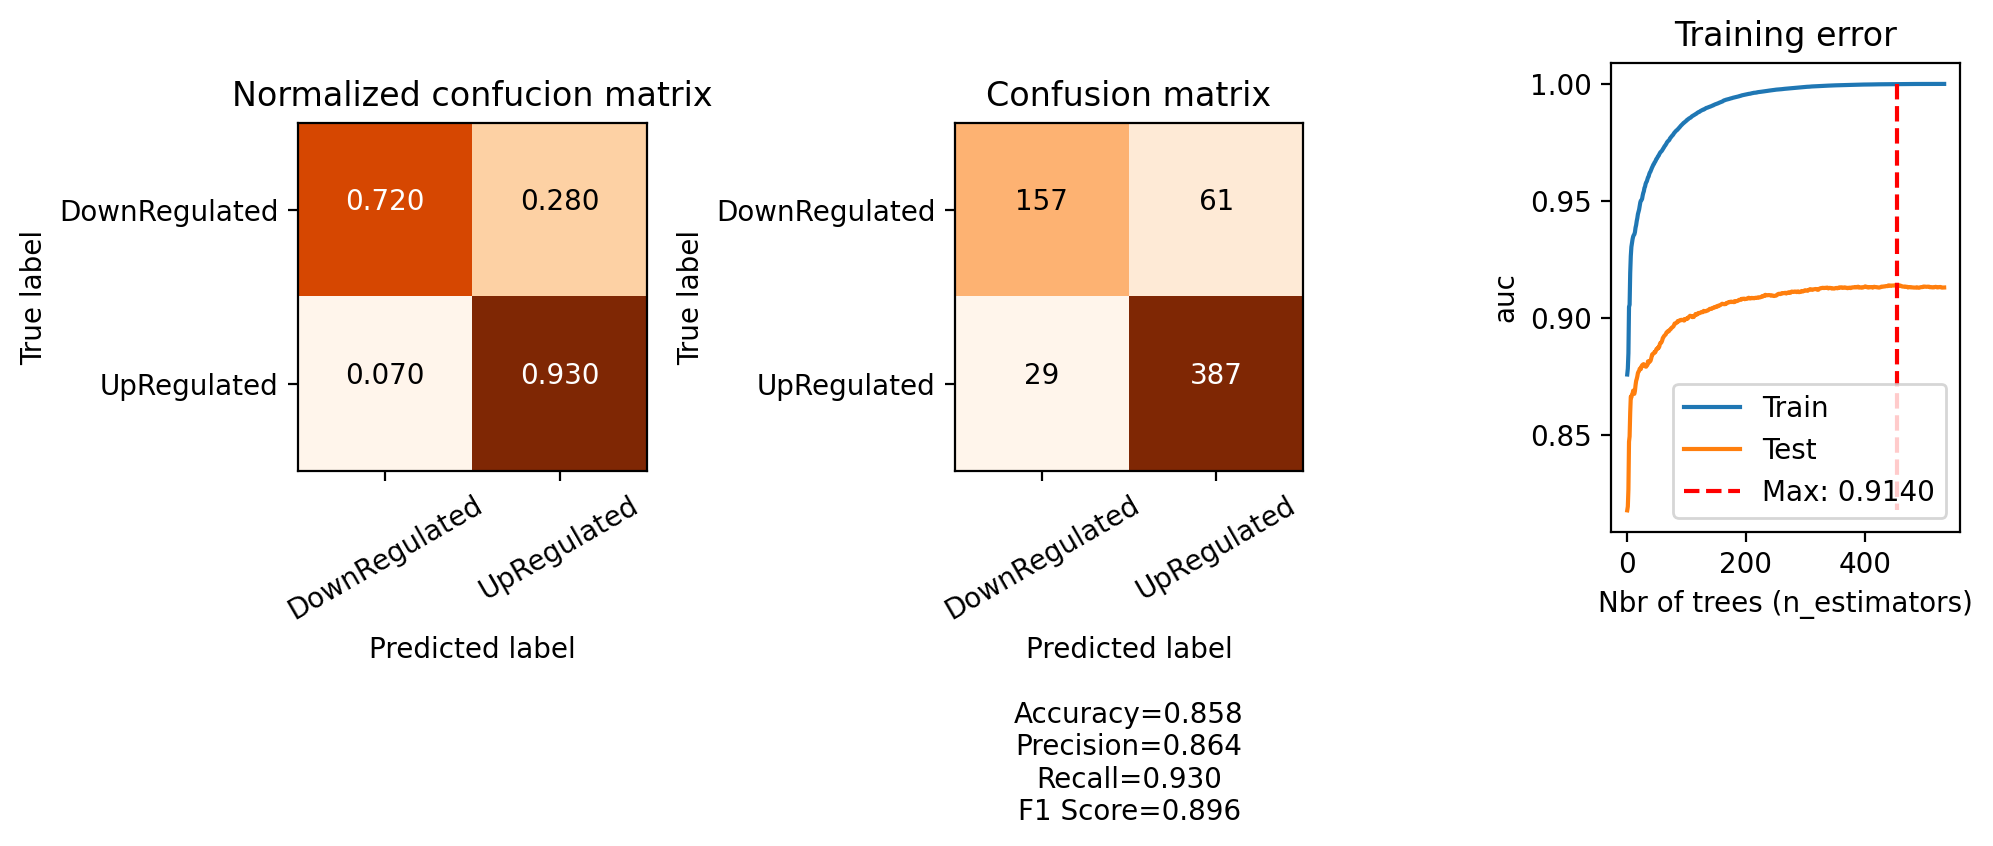

In [345]:
binary_low.plot_results("ESR1", figsize=(10,4))

## 3 class model predicting 'low', 'zero' or 'high' expression

In [323]:
model = mb.CellLevelModel("Cancer", ["ESR1"])
model.build_datasets(output_type="3_classes")

Building ESR1... Completed


In [257]:
model_params = {'objective': 'reg:squarederror',
 'base_score': 0.5,
 'num_class' : 3,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.025,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 5,
 'missing': float("nan"),
 'monotone_constraints': '()',
 'n_estimators': 1000,
 'n_jobs': 90,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': 0,
 'seed': None}

In [324]:
model.build_model(model_params,build_single_models=True, cv=0)

CANCER - ESR1 


-------------ESR1-------------
   Building prediction model for ESR1 using early stopping ...
MODEL BUILDING COMPLETE




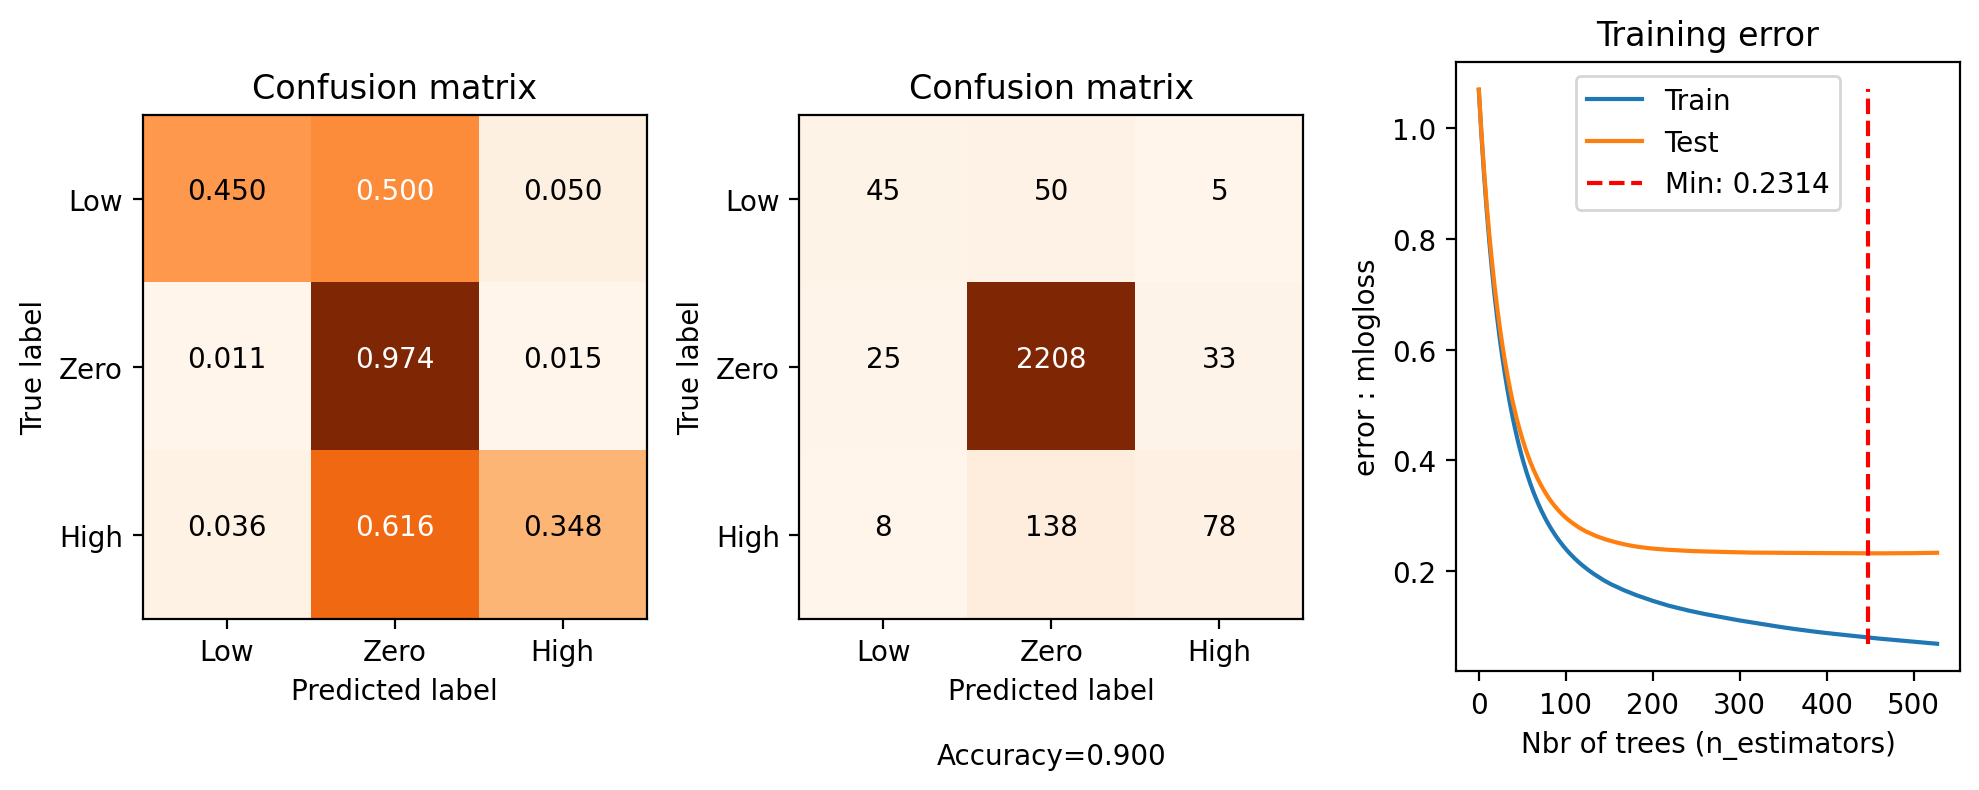

In [312]:
model.plot_results("ESR1", figsize=(10,4))

In [187]:
model.cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
Cancer-ESR1,NaN,NaN,NaN,NaN,0.227798,0.010764,0.095673,0.002675


In [121]:
(model.datasets["ESR1"]["y_test"]==0).sum()

2

In [321]:
for cell_type in cell_types:
    print("==================================================")
    model = mb.CellLevelModel(cell_type, genes)
    model.build_datasets(output_type="3_classes")
    model.build_model(params)
    models[cell_type] = model

Building ESR1... Completed
Building ERBB2... Completed
Building CDK1... Completed
Building CDK4... Completed
B_CELL - ESR1 ERBB2 CDK1 CDK4 


-------------ESR1-------------
   Performing 5 fold cross-validation on ESR1 -  

KeyboardInterrupt: 

# Improving models

In [67]:
params = {'objective': "binary:logistic",
 'base_score': 0.5,
 'num_class' : 1,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.025,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 5,
 'missing': float("nan"),
 'monotone_constraints': '()',
 'n_estimators': 2000,
 'n_jobs': 40,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'seed': None}

In [9]:
import src.data_handling as dh

In [10]:
VS = dh.VariableSelector("Cancer")

In [170]:
X, y, a = VS.extract_data("ESR1", diff_lim=0, verbose=1, select_n=5000)

Counting NaNs:


  0%|          | 0/28431 [00:00<?, ?it/s]

Computing correlation and p-value:


  0%|          | 0/28431 [00:00<?, ?it/s]

Selected 5050 input genes with alpha = 0.0002


In [173]:
Y_bin = pd.cut(y, bins=[-99,0.5,99],labels=["0","1"])

In [174]:
Y_bin = pd.to_numeric(Y_bin)

In [19]:
from sklearn.model_selection import train_test_split

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_bin, random_state=42)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

In [177]:
X_train.shape

(9712, 5050)

In [178]:
y_train.shape

(9712,)

In [75]:
Train_M = xgb.DMatrix(X_train, label=y_train)

In [76]:
local_cv_result = xgb.cv(params,
                         Train_M,
                         num_boost_round=800,
                         early_stopping_rounds=100,  
                         nfold=5, metrics=["auc"], 
                         stratified=True,
                         verbose_eval=100,
                         seed=42)

In [77]:
local_cv_result

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.924807,0.003689,0.899476,0.014358
1,0.929545,0.006615,0.905079,0.016487
2,0.935581,0.004968,0.911885,0.013952
3,0.937811,0.006021,0.914997,0.013788
4,0.941175,0.004590,0.919407,0.009784
...,...,...,...,...
395,0.993410,0.000467,0.951234,0.005532
396,0.993439,0.000470,0.951235,0.005540
397,0.993477,0.000472,0.951271,0.005538
398,0.993513,0.000467,0.951267,0.005547


In [81]:
params["n_estimators"] = local_cv_result.shape[0]

In [82]:
clf = xgb.XGBClassifier(**params, use_label_encoder=False)

In [84]:
clf.fit(X_train, y_train,
         eval_set=[(X_train, y_train)], 
         verbose=40, eval_metric=["auc"])

[0]	validation_0-auc:0.91457
[40]	validation_0-auc:0.95649
[80]	validation_0-auc:0.96530
[120]	validation_0-auc:0.97121
[160]	validation_0-auc:0.97501
[200]	validation_0-auc:0.97888
[240]	validation_0-auc:0.98273
[280]	validation_0-auc:0.98545
[320]	validation_0-auc:0.98773
[360]	validation_0-auc:0.98955
[399]	validation_0-auc:0.99110


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=40, num_class=1, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [85]:
y_pred = clf.predict(X_test)

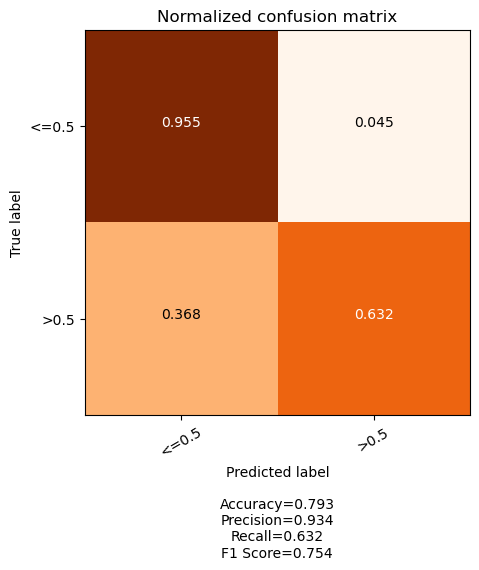

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
modules.plot_confusion_matrix(cm_norm, labels=["<=0.5", ">0.5"], fig=fig, ax=ax, title="Normalized confusion matrix")
plt.show()

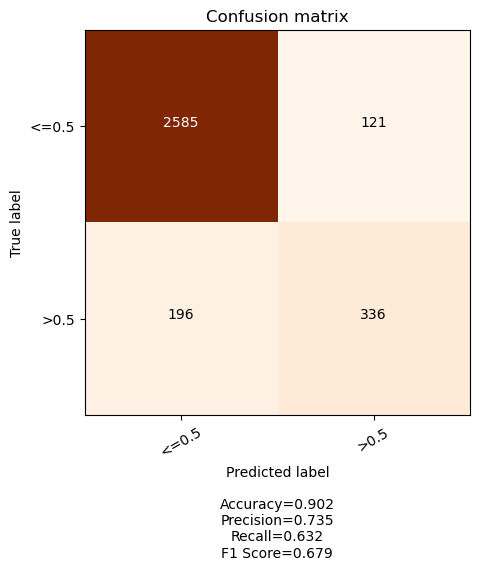

In [88]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
modules.plot_confusion_matrix(cm, labels=["<=0.5", ">0.5"], fig=fig, ax=ax, title="Confusion matrix")
plt.show()

# Balancing classes

In [101]:
import numpy as np

In [91]:
from imblearn.over_sampling import SMOTE

### Oversampling

In [193]:
sm = SMOTE(random_state=42)

In [194]:
X_no_nan = X_train.replace({np.nan:0})

In [195]:
X_res, y_res = sm.fit_resample(X_no_nan, y_train)

In [196]:
X_res = X_res.replace({0:np.nan})

In [183]:
Train_M_res = xgb.DMatrix(X_res, label=y_res)

In [184]:
local_cv_result = xgb.cv(params,
                         Train_M_res,
                         num_boost_round=2000,
                         early_stopping_rounds=100,  
                         nfold=5, metrics=["auc"], 
                         stratified=False,
                         verbose_eval=100,
                         seed=42)

In [185]:
local_cv_result.iloc[-2:]

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
1563,0.013998,0.000381,0.110633,0.005452
1564,0.013983,0.000378,0.110627,0.005456


In [197]:
params["n_estimators"] = 800

In [198]:
clf = xgb.XGBClassifier(**params, use_label_encoder=False)

In [203]:
clf.fit(X_res, y_res, 
        eval_set=[(X_res, y_res)], 
        verbose=200, 
        eval_metric=["auc", "logloss"])

[0]	validation_0-auc:0.95374	validation_0-logloss:0.67546
[200]	validation_0-auc:0.99533	validation_0-logloss:0.11915
[400]	validation_0-auc:0.99851	validation_0-logloss:0.07656
[600]	validation_0-auc:0.99945	validation_0-logloss:0.05563
[799]	validation_0-auc:0.99976	validation_0-logloss:0.04293


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=40, num_class=1, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [204]:
y_pred = clf.predict(X_test)

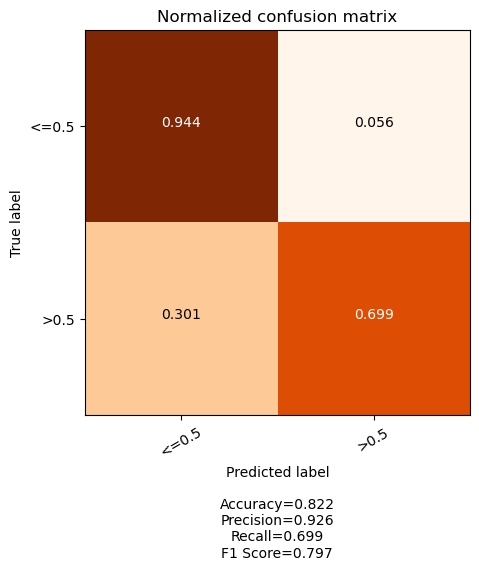

In [205]:
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
modules.plot_confusion_matrix(cm_norm, labels=["<=0.5", ">0.5"], fig=fig, ax=ax, title="Normalized confusion matrix")
plt.show()

### Undersampling

In [144]:
sm_u = SMOTE(sampling_strategy='not minority')

In [145]:
X_res2, y_res2 = sm_u.fit_resample(X_no_nan, y_train)

In [147]:
X_res2 = X_res2.replace({0:np.nan})

In [149]:
Train_M_res2 = xgb.DMatrix(X_res2, label=y_res2)

In [157]:
cv_result = xgb.cv(params,
                         Train_M_res2,
                         num_boost_round=2000,
                         early_stopping_rounds=100,  
                         nfold=5, metrics=["auc"], 
                         stratified=False,
                         verbose_eval=100,
                         seed=42)

In [163]:
cv_result.iloc[-10:]

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
581,0.997344,0.000540,0.951585,0.004720
582,0.997357,0.000537,0.951583,0.004721
583,0.997368,0.000536,0.951576,0.004728
584,0.997375,0.000536,0.951588,0.004730
585,0.997390,0.000533,0.951601,0.004719
586,0.997403,0.000532,0.951632,0.004691
587,0.997414,0.000532,0.951631,0.004720
588,0.997429,0.000531,0.951648,0.004727
589,0.997440,0.000531,0.951656,0.004708
590,0.997450,0.000527,0.951668,0.004711


In [158]:
params["n_estimators"] = local_cv_result.shape[0]

In [159]:
clf = xgb.XGBClassifier(**params, use_label_encoder=False)

In [160]:
clf.fit(X_res2, y_res2, 
        eval_set=[(X_res2, y_res2)], 
        verbose=200, 
        eval_metric=["logloss"])

[0]	validation_0-logloss:0.67562
[40]	validation_0-logloss:0.33207
[80]	validation_0-logloss:0.23066
[120]	validation_0-logloss:0.19099
[160]	validation_0-logloss:0.17133
[200]	validation_0-logloss:0.15704
[240]	validation_0-logloss:0.14488
[280]	validation_0-logloss:0.13611
[320]	validation_0-logloss:0.12847
[360]	validation_0-logloss:0.12219
[400]	validation_0-logloss:0.11640
[440]	validation_0-logloss:0.11107
[480]	validation_0-logloss:0.10585
[520]	validation_0-logloss:0.10135
[560]	validation_0-logloss:0.09689
[600]	validation_0-logloss:0.09210
[640]	validation_0-logloss:0.08804
[680]	validation_0-logloss:0.08436
[720]	validation_0-logloss:0.08075
[760]	validation_0-logloss:0.07708
[800]	validation_0-logloss:0.07391
[840]	validation_0-logloss:0.07102
[880]	validation_0-logloss:0.06804
[920]	validation_0-logloss:0.06508
[960]	validation_0-logloss:0.06226
[1000]	validation_0-logloss:0.05996
[1040]	validation_0-logloss:0.05758
[1080]	validation_0-logloss:0.05521
[1120]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=40, num_class=1, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [161]:
y_pred = clf.predict(X_test)

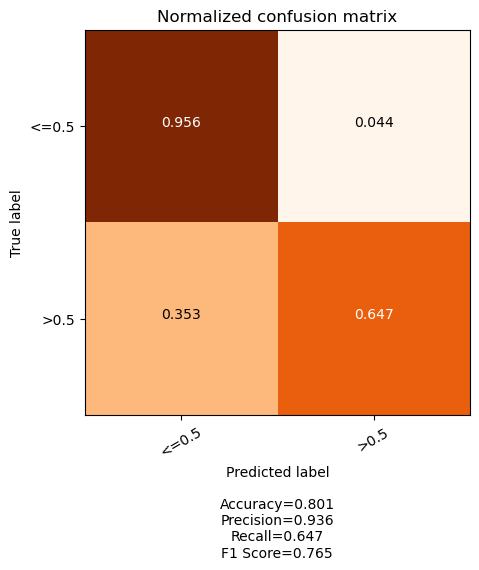

In [162]:
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
modules.plot_confusion_matrix(cm_norm, labels=["<=0.5", ">0.5"], fig=fig, ax=ax, title="Normalized confusion matrix")
plt.show()